In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
import re


from torch_geometric.data import HeteroData, Batch
from torch_geometric.transforms import ToUndirected
from torch_geometric.loader import LinkNeighborLoader
from sklearn.manifold import TSNE

In [58]:
# =========================
# 1. Build the Heterogeneous Graph
# =========================

def get_graph(dataset_folder):
    # Load edge data (convert lists to tensors if necessary)
    # Recipe -> Ingredient edges
    r_i_src, r_i_dst, r_i_weight = torch.load(os.path.join(dataset_folder, 'edge_r2i_src_dst_weight.pt'))
    r_i_src = torch.tensor(r_i_src, dtype=torch.long)
    r_i_dst = torch.tensor(r_i_dst, dtype=torch.long)
    r_i_weight = torch.tensor(r_i_weight, dtype=torch.float)

    # Recipe -> Recipe edges
    r_r_src, r_r_dst, r_r_weight = torch.load(os.path.join(dataset_folder, 'edge_r2r_src_and_dst_and_weight.pt'))
    r_r_src = torch.tensor(r_r_src, dtype=torch.long)
    r_r_dst = torch.tensor(r_r_dst, dtype=torch.long)
    r_r_weight = torch.tensor(r_r_weight, dtype=torch.float)

    # Ingredient -> Ingredient edges
    i_i_src, i_i_dst, i_i_weight = torch.load(os.path.join(dataset_folder, 'edge_i2i_src_and_dst_and_weight.pt'))
    i_i_src = torch.tensor(i_i_src, dtype=torch.long)
    i_i_dst = torch.tensor(i_i_dst, dtype=torch.long)
    i_i_weight = torch.tensor(i_i_weight, dtype=torch.float)

    # User -> Recipe edges (all, train, val, test splits)
    all_u2r = torch.load(os.path.join(dataset_folder, 'all_train_val_test_edge_u_rate_r_src_and_dst_and_weight.pt'))
    # all_u2r is a tuple: (all, train, val, test)
    all_u2r_src_dst_weight = all_u2r[0]
    train_u2r_src_dst_weight = all_u2r[1]
    val_u2r_src_dst_weight = all_u2r[2]
    test_u2r_src_dst_weight = all_u2r[3]
    
    # For the full graph, we use "all" edges:
    u_rate_r_src, u_rate_r_dst, u_rate_r_weight = all_u2r_src_dst_weight
    u_rate_r_src = torch.tensor(u_rate_r_src, dtype=torch.long)
    u_rate_r_dst = torch.tensor(u_rate_r_dst, dtype=torch.long)
    u_rate_r_weight = torch.tensor(u_rate_r_weight, dtype=torch.float)

    # Number of nodes (from your logs)
    num_recipe = 68794
    num_ingredient = 8847
    num_user = 7959

    data = HeteroData()
    data['recipe'].num_nodes = num_recipe
    data['ingredient'].num_nodes = num_ingredient
    data['user'].num_nodes = num_user

    # Add edges for each relation
    # recipe -> ingredient ("r-i")
    data['recipe', 'r-i', 'ingredient'].edge_index = torch.stack([r_i_src, r_i_dst], dim=0)
    data['recipe', 'r-i', 'ingredient'].edge_weight = r_i_weight
    # ingredient -> recipe ("i-r")
    data['ingredient', 'i-r', 'recipe'].edge_index = torch.stack([r_i_dst, r_i_src], dim=0)
    data['ingredient', 'i-r', 'recipe'].edge_weight = r_i_weight

    # recipe -> recipe ("r-r")
    data['recipe', 'r-r', 'recipe'].edge_index = torch.stack([r_r_src, r_r_dst], dim=0)
    data['recipe', 'r-r', 'recipe'].edge_weight = r_r_weight

    # ingredient -> ingredient ("i-i")
    data['ingredient', 'i-i', 'ingredient'].edge_index = torch.stack([i_i_src, i_i_dst], dim=0)
    data['ingredient', 'i-i', 'ingredient'].edge_weight = i_i_weight

    # user -> recipe ("u-r")
    data['user', 'u-r', 'recipe'].edge_index = torch.stack([u_rate_r_src, u_rate_r_dst], dim=0)
    data['user', 'u-r', 'recipe'].edge_weight = u_rate_r_weight

    # recipe -> user ("r-u")
    data['recipe', 'r-u', 'user'].edge_index = torch.stack([u_rate_r_dst, u_rate_r_src], dim=0)
    data['recipe', 'r-u', 'user'].edge_weight = u_rate_r_weight

    # (Optional) Make the graph undirected if desired.
    # data = ToUndirected()(data)

    # Load node features
    recipe_instr_features = torch.load(os.path.join(dataset_folder, 'recipe_nodes_avg_instruction_features.pt'))
    ingredient_nutrient_features = torch.load(os.path.join(dataset_folder, 'ingredient_nodes_nutrient_features.pt'))
    data['recipe'].x = recipe_instr_features   # shape: [68794, feature_dim_recipe]
    data['ingredient'].x = ingredient_nutrient_features  # shape: [8847, feature_dim_ingredient]

    return data, all_u2r, train_u2r_src_dst_weight, val_u2r_src_dst_weight, test_u2r_src_dst_weight

dataset_folder = "data/"
data, all_u2r, train_u2r_src_dst_weight, val_u2r_src_dst_weight, test_u2r_src_dst_weight = get_graph(dataset_folder)
print(data)

HeteroData(
  recipe={
    num_nodes=68794,
    x=[68794, 1024],
  },
  ingredient={
    num_nodes=8847,
    x=[8847, 46],
  },
  user={ num_nodes=7959 },
  (recipe, r-i, ingredient)={
    edge_index=[2, 463485],
    edge_weight=[463485],
  },
  (ingredient, i-r, recipe)={
    edge_index=[2, 463485],
    edge_weight=[463485],
  },
  (recipe, r-r, recipe)={
    edge_index=[2, 647146],
    edge_weight=[647146],
  },
  (ingredient, i-i, ingredient)={
    edge_index=[2, 146188],
    edge_weight=[146188],
  },
  (user, u-r, recipe)={
    edge_index=[2, 135353],
    edge_weight=[135353],
  },
  (recipe, r-u, user)={
    edge_index=[2, 135353],
    edge_weight=[135353],
  }
)


In [59]:
for node_type in data.node_types:
    print(f"{node_type} has {data[node_type].num_nodes} nodes, x shape = {data[node_type].x.shape if 'x' in data[node_type] else 'no features'}")

for edge_type in data.edge_types:
    edge_idx = data[edge_type].edge_index
    print(f"Edge type {edge_type} has {edge_idx.size(1)} edges, edge_weight shape = {data[edge_type].edge_weight.shape if 'edge_weight' in data[edge_type] else 'no weights'}")

recipe has 68794 nodes, x shape = torch.Size([68794, 1024])
ingredient has 8847 nodes, x shape = torch.Size([8847, 46])
user has 7959 nodes, x shape = no features
Edge type ('recipe', 'r-i', 'ingredient') has 463485 edges, edge_weight shape = torch.Size([463485])
Edge type ('ingredient', 'i-r', 'recipe') has 463485 edges, edge_weight shape = torch.Size([463485])
Edge type ('recipe', 'r-r', 'recipe') has 647146 edges, edge_weight shape = torch.Size([647146])
Edge type ('ingredient', 'i-i', 'ingredient') has 146188 edges, edge_weight shape = torch.Size([146188])
Edge type ('user', 'u-r', 'recipe') has 135353 edges, edge_weight shape = torch.Size([135353])
Edge type ('recipe', 'r-u', 'user') has 135353 edges, edge_weight shape = torch.Size([135353])


In [60]:
def create_split_data(data, split_u2r):
    """
    Given a HeteroData object and a tuple split_u2r = (src, dst, weight),
    update the "u-r" and "r-u" relations with the provided split.
    """
    split_src, split_dst, split_weight = split_u2r
    split_src = torch.tensor(split_src, dtype=torch.long)
    split_dst = torch.tensor(split_dst, dtype=torch.long)
    split_weight = torch.tensor(split_weight, dtype=torch.float)
    
    data['user', 'u-r', 'recipe'].edge_index = torch.stack([split_src, split_dst], dim=0)
    data['user', 'u-r', 'recipe'].edge_weight = split_weight
    
    data['recipe', 'r-u', 'user'].edge_index = torch.stack([split_dst, split_src], dim=0)
    data['recipe', 'r-u', 'user'].edge_weight = split_weight
    return data

train_data = create_split_data(copy.deepcopy(data), train_u2r_src_dst_weight)
val_data   = create_split_data(copy.deepcopy(data), val_u2r_src_dst_weight)
test_data  = create_split_data(copy.deepcopy(data), test_u2r_src_dst_weight)


In [61]:
from torch_geometric.loader import LinkNeighborLoader
def unify_train_val_collate(data_list):
    """
    A collate function that performs the default PyG collation, 
    then checks if PyG assigned an attribute `edge_label`.
    If so, we copy it into `edge_attr`.
    """
    batch = Batch.from_data_list(data_list)
    edge_store = batch['user','u-r','recipe']
    # If PyG's negative sampler attached `.edge_label`, unify it into `edge_attr`.
    if hasattr(edge_store, 'edge_label'):
        edge_store.edge_attr = getattr(edge_store, 'edge_label')
    return batch

# For training, we use train_data
train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[20, 20],
    edge_label_index=('user','u-r','recipe'),
    batch_size=1024,
    shuffle=True,
    neg_sampling_ratio=5,   # built-in negative sampling
    collate_fn=unify_train_val_collate
)

val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 20],
    edge_label_index=('user','u-r','recipe'),
    batch_size=128,
    shuffle=False,
    neg_sampling_ratio=5,   # built-in negative sampling
    collate_fn=unify_train_val_collate
)

print('# of batches in train_loader:', len(train_loader))
print('# of batches in val_loader:', len(val_loader))

# of batches in train_loader: 117
# of batches in val_loader: 63


In [74]:
n_test_negs = 100  # number of negatives per positive edge for testing
dataset_folder = "data/"

def load_test_negatives(dataset_folder):
    """
    Loads a dictionary mapping each user ID to a list of negative recipe IDs.
    Expects the file 'test_negatives_100.txt' in dataset_folder.
    """
    user2negs = {}
    filename = os.path.join(dataset_folder, 'test_negatives_100.txt')
    with open(filename, "r") as f:
        lines = f.readlines()
        for line in tqdm(lines, desc="Loading test negatives"):
            line = line.strip()
            if not line:
                continue
            # Assume the first token looks like "(123)" or "u123"
            user_str = line.split('\t')[0]
            user = int(re.sub(r'\D', '', user_str))
            negs = [int(neg) for neg in line.split('\t')[1:]]
            user2negs[user] = negs
    return user2negs

user2negs = load_test_negatives(dataset_folder)

test_edge_store = test_data['user','u-r','recipe']
test_pos_edges = test_edge_store.edge_index  # shape [2, num_test_pos]
# Row 0 = user IDs, row 1 = recipe IDs

# If your test split is a one-edge-per-user scenario, you might gather a dict:
# user2pos = { user_id: recipe_id }
# or if a user can have multiple test recipes, store them in a list.

user2pos = {}
src = test_pos_edges[0].tolist()
dst = test_pos_edges[1].tolist()
for u,r in zip(src, dst):
    user2pos.setdefault(u, []).append(r)  # handle multi-positives if needed

print("Number of test users in user2pos:", len(user2pos))
# Build test_loader with neg_sampling_ratio=0 and our custom collate function.
# `merged_edge_index` is your shape [2, E] tensor
test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[20, 20],
    edge_label_index=( ('user','u-r','recipe'), merged_edge_index ),
    edge_label=merged_labels,  # shape [E]
    batch_size=128,
    shuffle=False,
    neg_sampling_ratio=0,
)

print('# of batches in test_loader:', len(test_loader))

Loading test negatives: 100%|██████████| 7959/7959 [00:00<00:00, 89166.38it/s]

Number of test users in user2pos: 7959


NameError: name 'merged_labels' is not defined

In [7]:
for batch in train_loader:
    print("Batch keys:", batch.keys())
    print("Edge index shape:", batch['user', 'u-r', 'recipe'].edge_index.shape)
    print("Edge label shape:", batch['user', 'u-r', 'recipe'].edge_label.shape)
    break

ImportError: 'NeighborSampler' requires either 'pyg-lib' or 'torch-sparse'

In [8]:
import torch
import time
import numpy as np
from src.models.baseRecommender import Recommender

# 1) Define a Trivial Model with Random Scores
class TrivialModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, batch):
        # This model returns random scores for each edge between 0 and 1
        edge_index = batch['user', 'u-r', 'recipe'].edge_index
        num_edges = edge_index.size(1)
        return torch.rand(num_edges, device=edge_index.device)  # Random scores in [0, 1]

# 2) Define a Trivial Recommender using the Random Model
class TrivialRecommender(Recommender):
    def __init__(self, device='cpu'):
        super().__init__(device=device)
        self.model = TrivialModel().to(device)

    def fit(self, data):
        # No training needed
        pass

# 3) Instantiate & Evaluate
trivial_recommender = TrivialRecommender(device='cpu')

print("Evaluating trivial recommender on validation split...")

val_start = time.time()
val_metrics = trivial_recommender.evaluate(val_loader, topk=[1,2,3,5,10], verbose=True)
val_end = time.time()

print(f"Trivial model evaluation on validation set took {val_end - val_start:.2f} seconds.")
print("Validation Metrics:", val_metrics)

Evaluating trivial recommender on validation split...


ImportError: 'NeighborSampler' requires either 'pyg-lib' or 'torch-sparse'

In [9]:
for batch in val_loader:
    edge_scores = trivial_recommender.model(batch)  # Model prediction scores
    print(edge_scores[:10])  # Check the first few scores
    break

ImportError: 'NeighborSampler' requires either 'pyg-lib' or 'torch-sparse'

In [46]:
data["recipe"]

{'num_nodes': 68794, 'x': tensor([[-4.7577e-07,  5.9157e-04,  7.5761e-16,  ...,  2.6294e-15,
          4.6648e-03,  1.4960e-18],
        [ 6.3345e-09, -2.7700e-05, -1.1196e-16,  ...,  1.6438e-17,
          1.8777e-03,  3.4776e-17],
        [ 5.6043e-07,  4.4443e-04, -8.4138e-14,  ...,  2.6699e-16,
          5.5984e-05,  6.1708e-21],
        ...,
        [ 1.2193e-02,  1.8029e-05, -3.5491e-14,  ...,  2.7744e-13,
          2.0622e-04,  9.3464e-18],
        [ 1.3699e-11,  1.1628e-05, -4.8603e-14,  ...,  6.7128e-16,
          2.4836e-02,  1.6493e-15],
        [ 5.8985e-12,  3.3551e-07, -2.3446e-14,  ...,  3.2265e-13,
          4.8656e-02,  2.3283e-22]])}

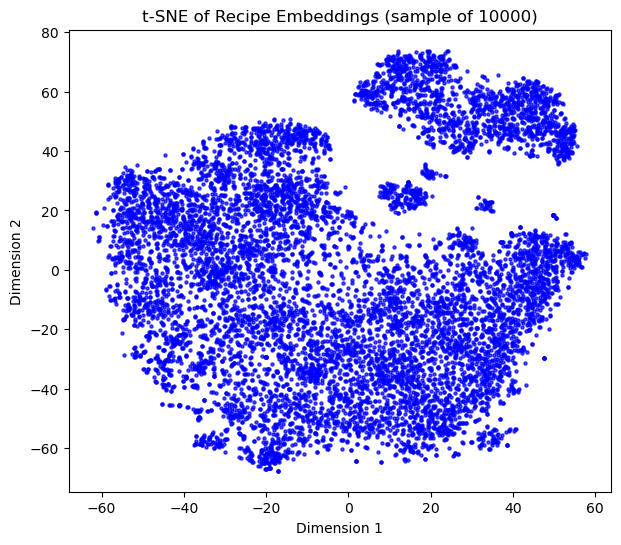

CPU times: user 1min 24s, sys: 10.5 s, total: 1min 35s
Wall time: 11.6 s


In [75]:
%%time
num_recipes = 68794
num_sample = 10000
indices = torch.randperm(num_recipes)[:num_sample]
sample_emb = data["recipe"].x[indices].detach().cpu().numpy()

# Perform TSNE in 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
emb_2d = tsne.fit_transform(sample_emb)

# Plot
plt.figure(figsize=(7,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], s=5, alpha=0.7, c="blue")
plt.title(f"t-SNE of Recipe Embeddings (sample of {num_sample})")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

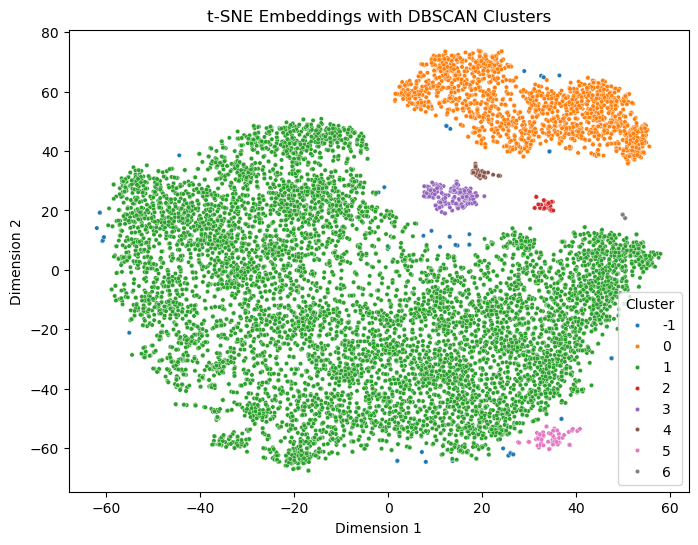

In [76]:
from sklearn.cluster import DBSCAN

# Cluster with DBSCAN
dbscan = DBSCAN(eps=3, min_samples=10)
cluster_labels = dbscan.fit_predict(emb_2d)

# Plot clusters
plt.figure(figsize=(8,6))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=cluster_labels, palette="tab10", s=10)
plt.title("t-SNE Embeddings with DBSCAN Clusters")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title="Cluster")
plt.show()

In [39]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=2, min_samples=10)  # Tune eps based on t-SNE
clusters = dbscan.fit_predict(emb_2d)

In [77]:
import pandas as pd
import numpy as np

# Dataframe with original embeddings
df_original = pd.DataFrame(sample_emb)
df_original['cluster'] = clusters

# Compute mean embeddings per cluster
cluster_means = df_original.groupby('cluster').mean()
print(cluster_means.head())

ValueError: Length of values (68794) does not match length of index (10000)

In [78]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(sample_emb)

plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=clusters, palette='tab10', s=5, alpha=0.7)
plt.title('PCA of Original Embeddings colored by DBSCAN Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.show()

print('Explained variance ratio:', pca.explained_variance_ratio_)

ValueError: All arrays must be of the same length

<Figure size 800x600 with 0 Axes>

In [79]:
# Compute cluster-wise mean embeddings
cluster_means = pd.DataFrame(sample_emb).assign(cluster=clusters).groupby('cluster').mean()

# Compute top features distinguishing clusters
for cluster in cluster_means.index:
    print(f"\nTop features for Cluster {cluster}:")
    top_features = np.argsort(-np.abs(cluster_means.loc[cluster]))[:5]
    for feature in top_features:
        print(f"Feature {feature}: Mean = {cluster_means.loc[cluster][feature]:.3f}")

ValueError: Length of values (68794) does not match length of index (10000)

In [80]:
from sklearn.metrics.pairwise import euclidean_distances

centroids = []
for cluster_label in set(clusters):
    cluster_points = sample_emb[clusters == cluster]
    centroid = np.mean(cluster_points, axis=0)
    distances = np.linalg.norm(cluster_points - centroid, axis=1)
    representative_index = indices[clusters == cluster][np.argmin(distances)]
    print(f"Representative Recipe for Cluster {cluster}:", representative_index)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 10000 but corresponding boolean dimension is 68794

In [81]:
# Assuming labels are available:
labels = data["recipe"].x[indices].cpu().numpy()
df_labels = pd.DataFrame({'Cluster': clusters, 'Label': labels})
cluster_distribution = df_labels.groupby('Cluster')['Label'].value_counts(normalize=True)
print(cluster_distribution)

ValueError: Per-column arrays must each be 1-dimensional

In [63]:
import pandas as pd

# Load recipes dataset
recipes = pd.read_csv('/Users/samlaborde-balen/Desktop/MLP project/Project/RecipeMAG/data/kaggle_data/RAW_recipes.csv')

# Drop missing essential data and duplicates
recipes.dropna(subset=['name', 'ingredients', 'tags', 'steps'], inplace=True)
recipes.drop_duplicates(subset='name', inplace=True)

# Lowercase text fields for consistency
recipes['ingredients'] = recipes['ingredients'].str.lower()
recipes['tags'] = recipes['tags'].str.lower()

# Nutrition preprocessing function
def preprocess_nutrition(df):
    nutrition_cols = ['calories', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)',
                      'protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)']
    
    df[nutrition_cols] = df['nutrition'].str.split(",", expand=True)
    df['calories'] = df['calories'].str.replace('[','', regex=False)
    df['carbohydrates (PDV)'] = df['carbohydrates (PDV)'].str.replace(']','', regex=False)
    
    df[nutrition_cols] = df[nutrition_cols].astype(float)
    return df

# Apply nutrition preprocessing
recipes = preprocess_nutrition(recipes)

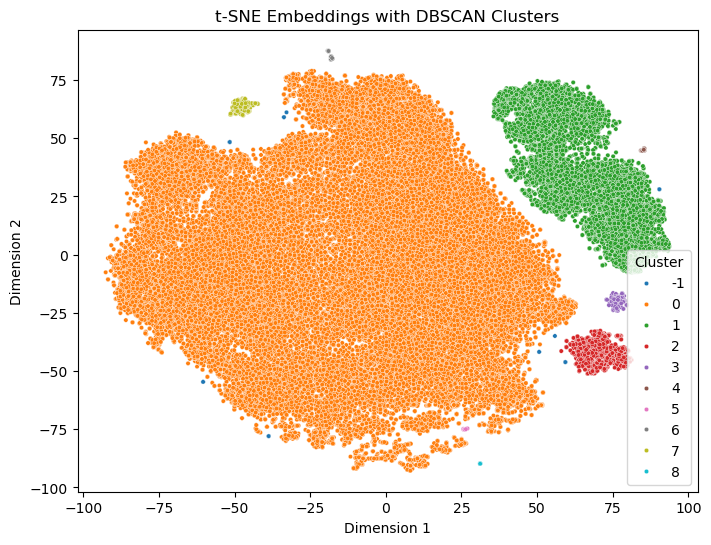

In [64]:
from sklearn.cluster import DBSCAN

# Cluster with DBSCAN
dbscan = DBSCAN(eps=3, min_samples=10)
cluster_labels = dbscan.fit_predict(emb_2d)

# Plot clusters
plt.figure(figsize=(8,6))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=cluster_labels, palette="tab10", s=10)
plt.title("t-SNE Embeddings with DBSCAN Clusters")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title="Cluster")
plt.show()

In [65]:
# Your indices and clusters from earlier (assuming they're computed already)
indices = indices.cpu().numpy()  # torch to numpy if necessary
cluster_labels = cluster_labels  # from DBSCAN
recipes_sampled = recipes.iloc[indices].copy()
recipes_sampled['cluster'] = cluster_labels

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [67]:
def analyze_cluster(df, cluster_id):
    cluster_data = df[df['cluster'] == cluster_id]
    ingredients = cluster_data['ingredients'].str.cat(sep=', ').split(', ')
    tags = cluster_data['tags'].str.cat(sep=',').split(',')

    ingredient_freq = pd.Series(ingredients).value_counts().head(10)
    tag_freq = pd.Series(tags).value_counts().head(10)
    
    print(f"\n--- Cluster {cluster_id} Analysis ---")
    print("Top Ingredients:\n", ingredient_freq)
    print("Top Tags:\n", tag_freq)

# Example usage for each cluster:
for cluster in sorted(recipes_sampled['cluster'].unique()):
    if cluster == -1:
        continue  # Skip noise cluster
    analyze_cluster(recipes_sampled, cluster)


--- Cluster 0 Analysis ---
Top Ingredients:
 'salt'             19455
'butter'           10537
'sugar'             9805
'onion'             8781
'eggs'              7391
'water'             6531
'milk'              5890
'garlic cloves'     5490
'flour'             5453
'olive oil'         5041
Name: count, dtype: int64
Top Tags:
 'preparation'         56334
'course'              52308
'time-to-make'        44901
'main-ingredient'     42238
'dietary'             39241
'easy'                30209
'occasion'            28099
'cuisine'             21596
'low-in-something'    19023
'main-dish'           17367
Name: count, dtype: int64

--- Cluster 1 Analysis ---
Top Ingredients:
 'salt'             3543
'butter'           1892
'sugar'            1727
'onion'            1622
'eggs'             1350
'water'            1219
'milk'             1061
'flour'             951
'garlic cloves'     942
'olive oil'         900
Name: count, dtype: int64
Top Tags:
 'preparation'         10097
'course'  

In [68]:
def analyze_cluster(df, cluster_id):
    cluster_data = df[df['cluster'] == cluster_id]
    ingredients = cluster_data['ingredients'].str.cat(sep=', ').split(', ')
    tags = cluster_data['tags'].str.cat(sep=',').split(',')

    ingredient_freq = pd.Series(ingredients).value_counts().head(10)
    tag_freq = pd.Series(tags).value_counts().head(10)
    
    print(f"\n--- Cluster {cluster_id} Analysis ---")
    print("Top Ingredients:\n", ingredient_freq)
    print("Top Tags:\n", tag_freq)

# Example usage for each cluster:
for cluster in sorted(recipes_sampled['cluster'].unique()):
    if cluster == -1:
        continue  # Skip noise cluster
    analyze_cluster(recipes_sampled, cluster)


--- Cluster 0 Analysis ---
Top Ingredients:
 'salt'             19455
'butter'           10537
'sugar'             9805
'onion'             8781
'eggs'              7391
'water'             6531
'milk'              5890
'garlic cloves'     5490
'flour'             5453
'olive oil'         5041
Name: count, dtype: int64
Top Tags:
 'preparation'         56334
'course'              52308
'time-to-make'        44901
'main-ingredient'     42238
'dietary'             39241
'easy'                30209
'occasion'            28099
'cuisine'             21596
'low-in-something'    19023
'main-dish'           17367
Name: count, dtype: int64

--- Cluster 1 Analysis ---
Top Ingredients:
 'salt'             3543
'butter'           1892
'sugar'            1727
'onion'            1622
'eggs'             1350
'water'            1219
'milk'             1061
'flour'             951
'garlic cloves'     942
'olive oil'         900
Name: count, dtype: int64
Top Tags:
 'preparation'         10097
'course'  

In [69]:
nutrition_cols = ['calories', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)',
                  'protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)']

nutrition_summary = recipes_sampled.groupby('cluster')[nutrition_cols].mean()
print("\nNutrition profiles by cluster:")
print(nutrition_summary)


Nutrition profiles by cluster:
           calories  total fat (PDV)  sugar (PDV)  sodium (PDV)  \
cluster                                                           
-1       348.488235        29.647059    48.411765     21.764706   
 0       486.340195        37.727473    86.187072     29.504873   
 1       479.378399        37.198800    82.848711     29.883632   
 2       462.438271        36.357886    77.375500     30.132906   
 3       502.473460        38.052133    95.838863     56.056872   
 4       371.773529        28.617647    60.117647     21.705882   
 5       499.000000        40.266667    55.333333     20.800000   
 6       635.380357        41.142857   186.750000     29.357143   
 7       535.841489        41.609929    98.347518     30.400709   
 8       495.276190        30.238095   177.095238     15.095238   

         protein (PDV)  saturated fat (PDV)  carbohydrates (PDV)  
cluster                                                           
-1           24.176471       

In [73]:
from sklearn.metrics import pairwise_distances_argmin_min
import numpy as np

representative_recipes = {}
for cluster in recipes_sampled['cluster'].unique():
    if cluster == -1:
        continue  # Skip noise cluster
    cluster_embeddings = sample_emb[cluster_labels == cluster]
    centroid = cluster_embeddings.mean(axis=0)
    closest, _ = pairwise_distances_argmin_min([centroid], cluster_embeddings)
    
    representative_recipe = recipes_sampled.iloc[closest[0]]
    representative_recipes[cluster] = representative_recipe['name']
    print(f"Cluster {cluster} representative recipe:", representative_recipe['name'])

Cluster 0 representative recipe: budget stretching beef and zucchini enchiladas w brown rice
Cluster 1 representative recipe: blue onion bistro s macaroni and blue cheese with chives
Cluster 2 representative recipe: black christmas
Cluster 3 representative recipe: allergy friendly double chocolate brownies
Cluster 4 representative recipe: chessie s fruit dip
Cluster 5 representative recipe: cube steak roll ups
Cluster 6 representative recipe: arabic 7 seven spice  bokharat
Cluster 7 representative recipe: berry tofu smoothie
Cluster 8 representative recipe: caramel mud cake cupcakes
